In [108]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

pd.set_option('display.max_columns', 500)

In [165]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [166]:
train['train'] = 1
test['train'] = 0
df = pd.concat([train, test])
df['logy'] = np.log1p(df['y'])
df.shape

(1489618, 44)

In [167]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["days"] = lb_make.fit_transform(df["days"])
df["direction"] = lb_make.fit_transform(df["direction"])
df["road_type"] = lb_make.fit_transform(df["road_type"])
df["urban_suburb"] = lb_make.fit_transform(df["urban_suburb"])
df["district"] = lb_make.fit_transform(df["district"])
df["time"] = lb_make.fit_transform(df["time"])

In [97]:
lb_make.fit(df["road_type"])
dict(zip(lb_make.classes_, lb_make.transform(lb_make.classes_)))

{'기타도로': 0, '도시고속도로': 1, '보조간선도로': 2, '주간선도로': 3}

In [168]:
def rain_level(rain) :
    if rain >= 30 :
        return 3
    else :
        if rain >=15 :
            return 2
        else :
            if rain >=3 :
                return 1
            else : return 0

def dust_PM2_level(dust) :
    if dust >= 76 :
        return 3
    else :
        if dust >=36 :
            return 2
        else :
            if dust >=16 :
                return 1
            else : return 0      

def dust_PM10_level(dust) :
    if dust >= 151 :
        return 3
    else :
        if dust >=81 :
            return 2
        else :
            if dust >=31 :
                return 1
            else : return 0

def wind_level(wind) :
    if wind >= 14 :
        return 3
    else :
        if wind >=9 :
            return 2
        else :
            if wind >=4 :
                return 1
            else : return 0

def O3_level(O3) :
    if O3 >= 0.151 :
        return 3
    else :
        if O3 >=0.091 :
            return 2
        else :
            if O3 >=0.031 :
                return 1
            else : return 0
            
df['dust_PM10_level'] = df['PM10'].apply(lambda x : dust_PM10_level(x))
df['dust_PM2_level'] = df['PM2.5'].apply(lambda x : dust_PM2_level(x))
df['rain_level'] = df['rain'].apply(lambda x : rain_level(x))       
df['wind_level'] = df['wind'].apply(lambda x : wind_level(x))            
df['O3_level'] = df['O3'].apply(lambda x : O3_level(x))

In [169]:
bins = [-40,-10,10,20,30,50]
bins_names = [0,1,2,3,4] # 구간별 이름
df['temp_level'] = pd.cut(df['temperature'], bins, labels=bins_names)

In [170]:
df['hsv'] = df['holiday'] + df['special'] + df['vacation']
df['cctv_kids'] = df['cctv'] + df['kids']

df['cctv_length'] = df['cctv'] / df['road_length']
df['kids_length'] = df['kids'] / df['road_length']
df['entrance_length'] = df['entrance'] / df['road_length']
df['signal_length'] = df['signal'] / df['road_length']

df['cctv_num'] = df['cctv'] / df['inter_num']
df['kids_num'] = df['kids'] / df['inter_num']
df['entrance_num'] = df['entrance'] / df['inter_num']
df['signal_num'] = df['signal'] / df['inter_num']

In [115]:
df = df.drop(['date','road_name','link_id','start_point','end_point'],axis = 1)
train = df[df.train == 1]
test = df[df.train == 0]

print('train shape : ', train.shape)
print('test shape : ', test.shape)

train shape :  (1042732, 55)
test shape :  (446886, 55)


# Modeling1
- 새로 추가한 변수 + labelEncoding

In [15]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs = -1)

In [16]:
X_train = train.drop(['y','logy','train'], axis = 1)
y_train = train['y']
y_log_train = train['logy']

X_test = test.drop(['y','logy','train'], axis = 1)
y_test = test['y']
y_log_test = test['logy']

In [17]:
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [48]:
print('test rmse {0:.3f} '.format(rmse(y_test, rf_pred)))

test rmse 3.347 


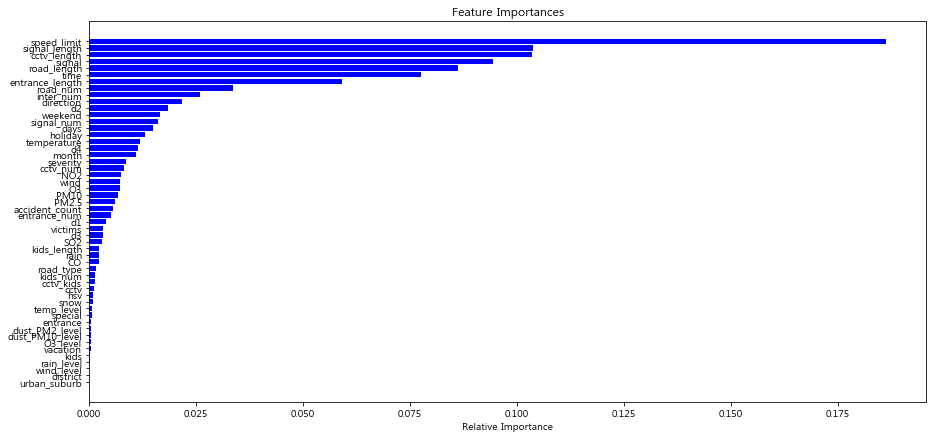

In [18]:
plt.figure(figsize = (15,7))
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Modeling 2
- labelEncoding + 새로 추가한 변수 + OnehotEncoding

In [36]:
df.columns

Index(['days', 'direction', 'road_length', 'road_num', 'road_type',
       'urban_suburb', 'district', 'holiday', 'special', 'vacation', 'time',
       'inter_num', 'd1', 'd2', 'd3', 'd4', 'victims', 'severity',
       'accident_count', 'temperature', 'wind', 'rain', 'snow', 'cctv', 'kids',
       'speed_limit', 'entrance', 'signal', 'SO2', 'CO', 'O3', 'NO2', 'PM10',
       'PM2.5', 'month', 'weekend', 'y', 'train', 'logy', 'dust_PM10_level',
       'dust_PM2_level', 'rain_level', 'wind_level', 'O3_level', 'temp_level',
       'hsv', 'cctv_kids', 'cctv_length', 'kids_length', 'entrance_length',
       'signal_length', 'cctv_num', 'kids_num', 'entrance_num', 'signal_num'],
      dtype='object')

In [34]:
df.shape

(1489618, 55)

In [171]:
cols = ['days','time','road_type','month','temp_level','rain_level','dust_PM10_level',
       'dust_PM2_level', 'rain_level', 'wind_level', 'O3_level']

df_dummy = pd.get_dummies(df, columns=cols)
df_dummy.shape

(1489618, 111)

In [172]:
df = pd.concat([df_dummy, df[cols]], axis = 1)
df.shape

(1489618, 122)

In [156]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred) : 
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [50]:
train = df[df.train == 1]
test = df[df.train == 0]

In [51]:
X_train = train.drop(['y','logy','train'], axis = 1)
y_train = train['y']
y_log_train = train['logy']

X_test = test.drop(['y','logy','train'], axis = 1)
y_test = test['y']
y_log_test = test['logy']

In [52]:
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [53]:
print('test rmse {0:.3f} '.format(rmse(y_test, rf_pred)))

test rmse 3.308 


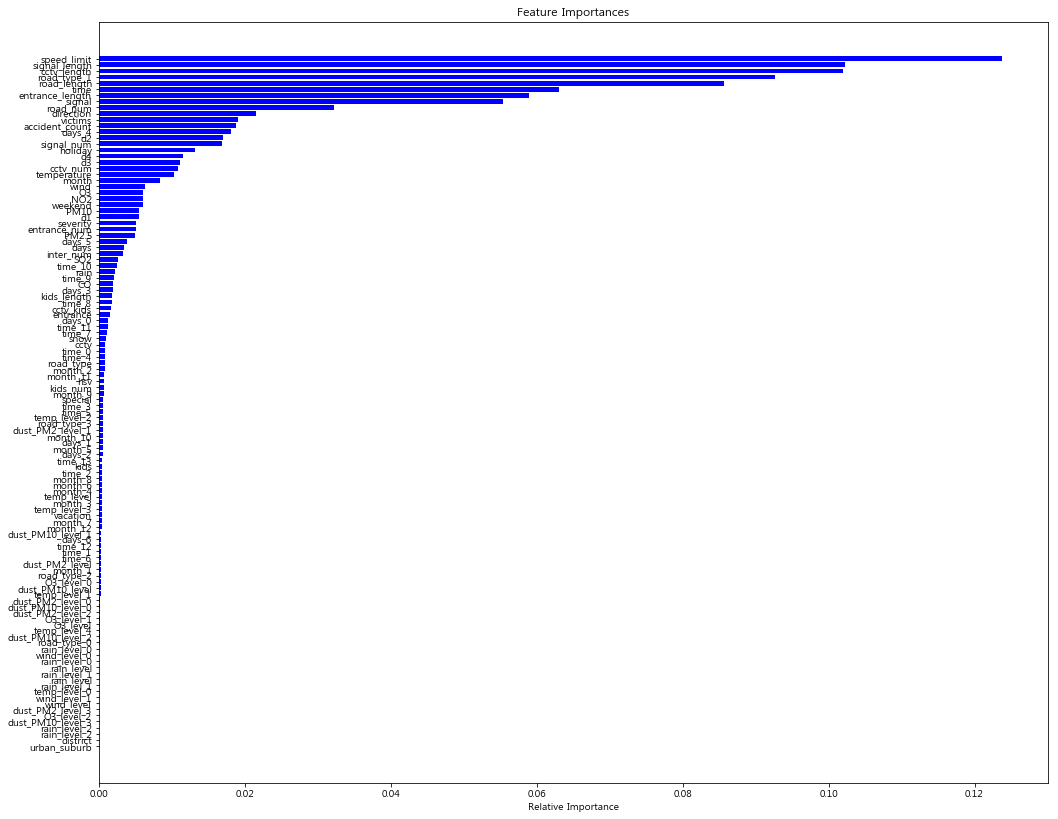

In [58]:
plt.figure(figsize = (17,14))
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# accident
- accident data에 있는 값들을 inter_num과 road_length 로 나눈다

In [64]:
df.shape

(1489618, 117)

In [173]:
cols = ['d1', 'd2', 'd3', 'd4','victims', 'severity', 'accident_count']

for col in cols :
    df[col + '_length'] = df[col] / df['road_length']
    df[col + '_num'] = df[col] / df['inter_num']

In [119]:
df.shape

(1489618, 131)

In [68]:
train = df[df.train == 1]
test = df[df.train == 0]

X_train = train.drop(['y','logy','train'], axis = 1)
y_train = train['y']
y_log_train = train['logy']

X_test = test.drop(['y','logy','train'], axis = 1)
y_test = test['y']
y_log_test = test['logy']

In [69]:
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [70]:
print('test rmse {0:.3f} '.format(rmse(y_test, rf_pred)))

test rmse 3.303 


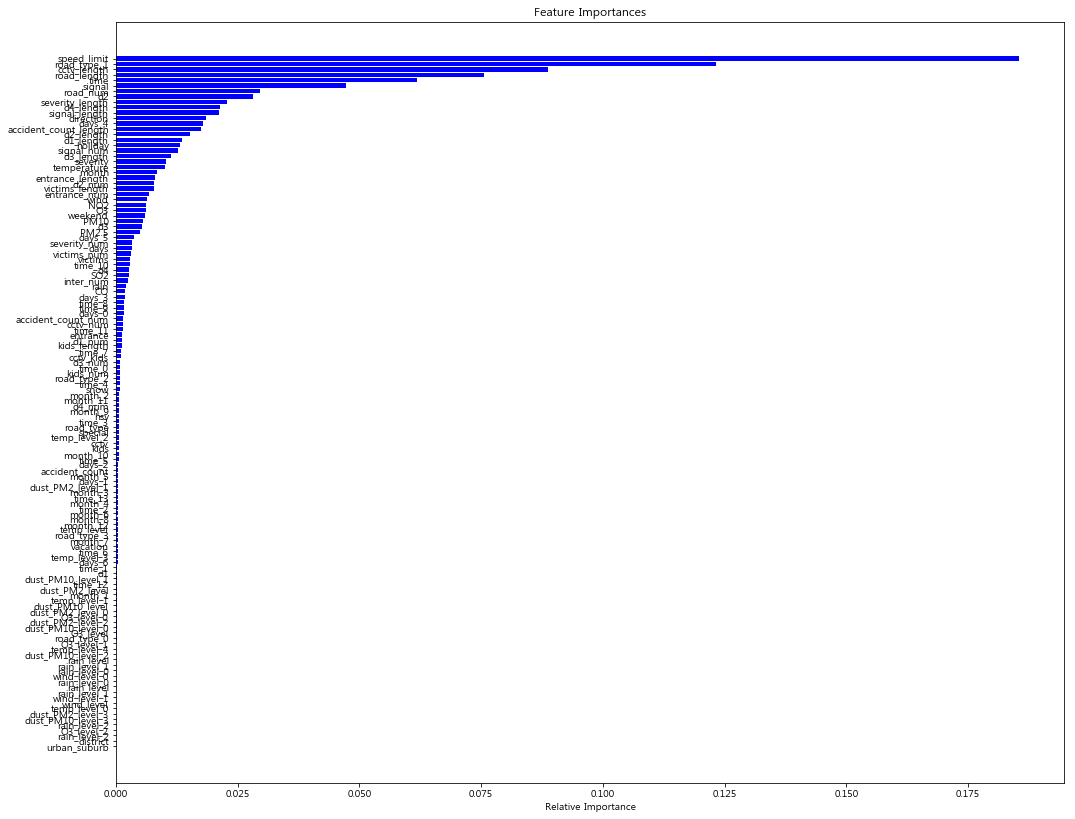

In [71]:
plt.figure(figsize = (17,14))
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Seasonal Effect

In [174]:
def seasonal(month) :
    if (month <= 5) & (month >= 3):
        return 0
    elif (month >= 6) & (month >= 8):
        return 1
    elif (month >= 9) & (month >= 11):
        return 2
    else :
        return 3
df['season'] = df['month'].apply(lambda x : seasonal(x))

In [159]:
def test_rmse (df) :
    train = df[df.train == 1]
    test = df[df.train == 0]

    X_train = train.drop(['y','logy','train'], axis = 1)
    y_train = train['y']
    y_log_train = train['logy']

    X_test = test.drop(['y','logy','train'], axis = 1)
    y_test = test['y']
    y_log_test = test['logy']
    
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    print('test rmse {0:.3f} '.format(rmse(y_test, rf_pred)))
    
    plt.figure(figsize = (17,14))
    features = X_train.columns
    importances = rf.feature_importances_
    indices = np.argsort(importances)

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

test rmse 3.313 


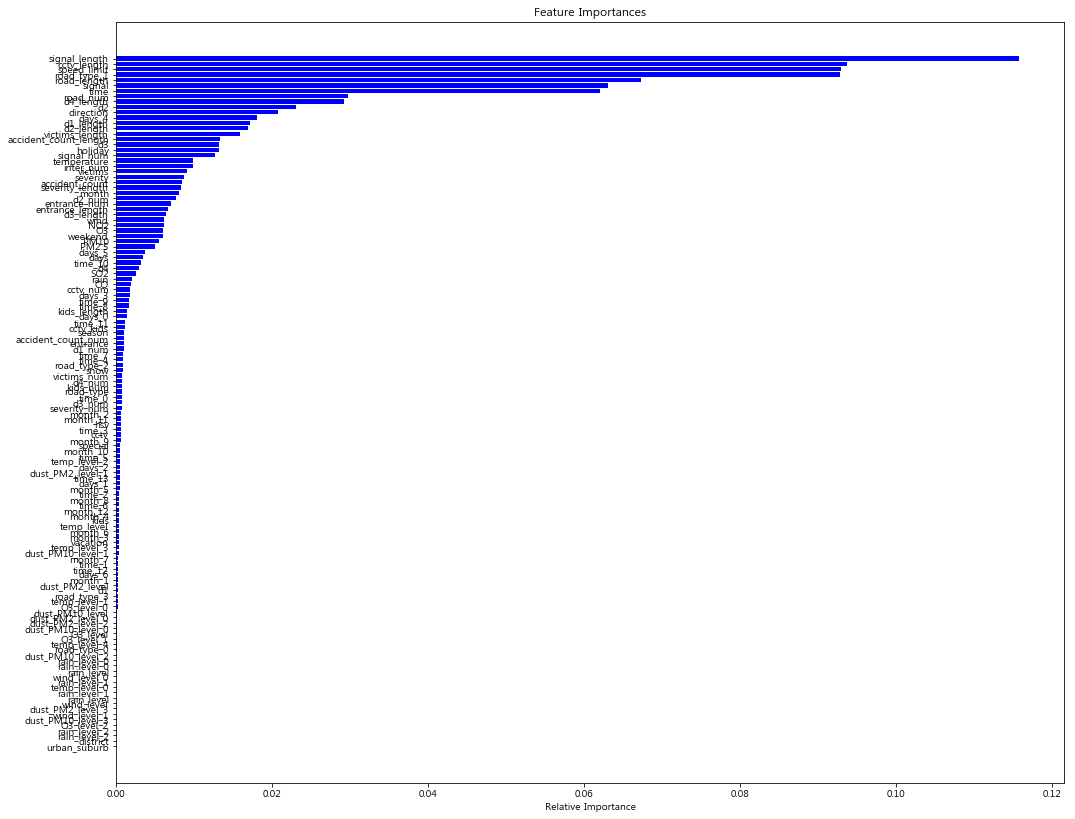

In [127]:
test_rmse(df)

# Cluster Variable

In [141]:
cluster_df = pd.read_csv('./cluster_df.csv')
cluster_df.shape

(298, 2)

In [179]:
cluster_df.columns

Index(['link_id', 'cluster'], dtype='object')

In [176]:
df = pd.merge(df, cluster_df)
df.shape

(1489618, 138)

In [177]:
df = df.drop(['date','road_name','link_id','start_point','end_point'],axis = 1)
train = df[df.train == 1]
test = df[df.train == 0]

print('train shape : ', train.shape)
print('test shape : ', test.shape)

train shape :  (1042732, 133)
test shape :  (446886, 133)


test rmse 3.301 


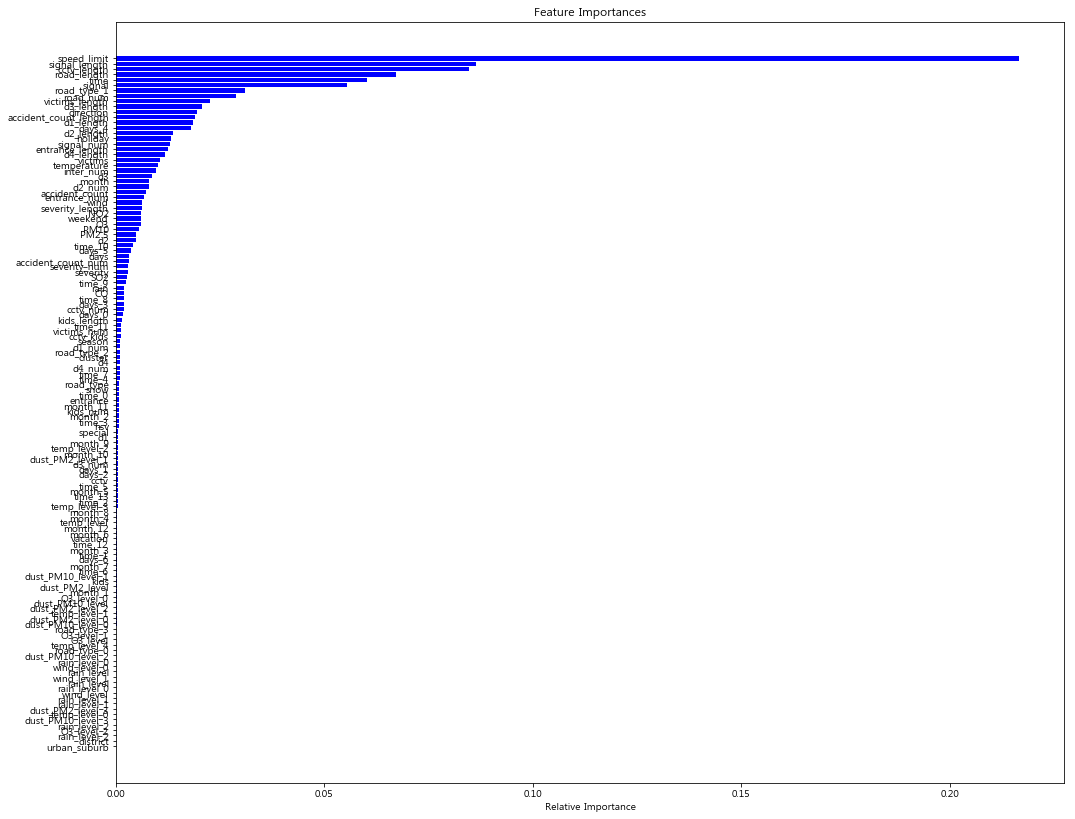

In [178]:
test_rmse(df)

## randomforest tuning

In [102]:
from bayes_opt import BayesianOptimization

In [121]:
train = df[df.train == 1]
test = df[df.train == 0]

In [122]:
X_train = train.drop(['y','train'], axis = 1)
y_train = train['y']

X_test = test.drop(['y','train'], axis = 1)
y_test = test['y']

In [125]:
X_train.shape

(1042732, 130)

In [134]:
from sklearn.model_selection import KFold, cross_val_score
cv = KFold(n_splits = 5, random_state = 333)
rf = RandomForestRegressor(n_jobs = -1)
rmse_value = np.sqrt(-cross_val_score(rf, X_train, y_train, scoring = 'neg_mean_squared_error', cv = cv))

print('RandomForest 5-Fold mean rmse : {0:.3f}'.format(rmse_value.mean()))

AttributeError: 'str' object has no attribute 'foramt'

In [136]:
rmse_value * 5

array([ 0.01610566,  0.02015624,  0.03297295,  0.00860324,  0.01432922])

In [139]:
def rf_cv(max_depth, min_samples_leaf, min_samples_split, n_estimators, cv = cv) :
    
    model = RandomForestRegressor(n_jobs = -1, max_depth = int(max_depth), min_samples_split = int(min_samples_split),
                                min_samples_leaf = int(min_samples_leaf), n_estimators = int(n_estimators))
    model.fit(X_train, y_train)
    model_pred = model.predict(X_test)
    
    rmse_value = np.sqrt(mean_squared_error(y_test, model_pred))
    
    return rmse_value

In [140]:
pbounds = {'max_depth' : (10,100),
          'min_samples_leaf' : (1,5),
          'min_samples_split' : (2,10),
          'n_estimators' : (50,1000)}

rf_BO = BayesianOptimization(f = rf_cv, pbounds = pbounds, verbose = 2, random_state = 333)
rf_BO.maximize(init_points = 3)

rpint(rf_BO)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------


KeyboardInterrupt: 